<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

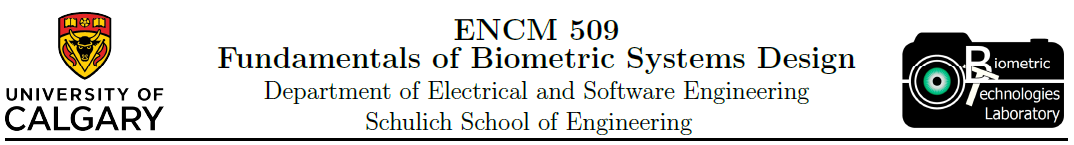

<center>
    <h1>Laboratory Experiment #3</h1>
    <h2>Biometric-based verification: Signature</h2>
</center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import os
import math

## Loading Signatures

In [2]:
# data folder:
# 'signature_samples/biometrics/'
# 'signature_samples/calgary/'
# 'signature_samples/hello/'

# this is the place where the folders "genuine" and "impostor" are
# change it to point to your dataset.
base_dir = os.getcwd() + '/signature_samples/biometrics/'

# "genuine" and "impostor" sub-directories
dir_authentic = base_dir + 'genuine/'
dir_impostor = base_dir + 'impostor/'

# amount of signatures to be loaded
total_signatures = 30
numForgedSigs = 30

# lists to store the loaded signatures
auth_lst = []
imp_lst = []

# loading 'total_signatures' signatures from both "authentic" and "impostor" 
for i in range(total_signatures):
    # columns: [X, Y, Pressure, Time]
    csv_auth = pd.read_csv(dir_authentic + '%d.csv' % (i+1))
    csv_imp = pd.read_csv(dir_impostor + '%d.csv' % (i+1))

    auth_lst.append(csv_auth.values)
    imp_lst.append(csv_imp.values)

In [3]:
print('Size of the "auth_lst" vector: %d' % (len(auth_lst)))
print('Size of the "imp_lst" vector: %d' % (len(imp_lst)))

Size of the "auth_lst" vector: 30
Size of the "imp_lst" vector: 30


## Classification: selecting subset to train

In [4]:
# number of signature samples to use for training the models
NUMTRAININGPATTERNS = 20

# number of Gaussian mixture components in the GMM
NUMGCOMPONENTS = 20

# usually we don't know the final size of train_set because
# each signature has different number of points. 
# to later on use 'concatenate', is necessary to take the first sample outside the loop
train_set = np.reshape(auth_lst[0], (-1,4))

# this for-loop put all the first "NUMTRAININGPATTERNS" in a huge matrix
# this matrix, stored in the varaible "train_set" will be used for the training
for i in range(1,NUMTRAININGPATTERNS):
    # taking from authentic/genuine
    sample = np.reshape(auth_lst[i], (-1,4))
    train_set = np.concatenate((train_set, sample), axis=0)

In [5]:
print('We will use these data for training the Gaussian Mixture Model')
print('The number of signatures for training is the first %d signatures from the set,' % (NUMTRAININGPATTERNS ))
print('and the number of Gaussian mixture components is %d' % (NUMGCOMPONENTS))

We will use these data for training the Gaussian Mixture Model
The number of signatures for training is the first 20 signatures from the set,
and the number of Gaussian mixture components is 20


### Training with the Gaussian Mixture Model

In [6]:
# Training the GaussianMixture model from Scikit-Learn library
# the .fit(...) will perform the training step using the "train_set" 
gmm = GaussianMixture(n_components=NUMGCOMPONENTS).fit(train_set)

### Testing with the remaining signature samples

In [7]:
# to store all the scores calculated
aScores = []

# going through the remaining signatures after removing the first 20 for training
for i in range(NUMTRAININGPATTERNS, total_signatures):
    # taking from authentic/genuine
    sample =  np.reshape(auth_lst[i], (-1,4))
    # compute the per-sample average log-likelihood of the given data.
    score = gmm.score(sample)
    print('%d: %.4f' % (i, score))
    # add the score calculated to the list aScores
    aScores.append(score)

20: -17.3736
21: -16.8427
22: -16.7020
23: -17.2111
24: -17.1763
25: -17.8725
26: -17.3109
27: -17.0516
28: -16.3662
29: -17.3631


### Testing with the forged (impostor) data

In [8]:
fScores = []
for i in range(numForgedSigs):
    # taking from the impostor
    sample =  np.reshape(imp_lst[i], (-1,4))
    score = gmm.score(sample)
    print('%d: %.4f' % (i, score))
    fScores.append(score)

0: -180.4165
1: -115.5159
2: -119.8340
3: -279.2886
4: -210.2396
5: -184.6556
6: -171.9276
7: -197.7891
8: -223.6665
9: -123.3490
10: -107.7250
11: -179.5909
12: -196.5119
13: -158.8719
14: -349.9926
15: -186.3628
16: -119.3641
17: -188.0987
18: -181.1702
19: -457.7860
20: -132.7039
21: -216.7310
22: -116.9105
23: -154.4297
24: -112.7462
25: -106.3558
26: -116.6972
27: -147.4621
28: -121.9183
29: -375.5042


### Calculating mean and std of the scores

In [9]:
# authentic set
aMu = np.mean(aScores)
aStd = np.std(aScores)

# impostor set
fMu = np.mean(fScores)
fStd = np.std(fScores)

print('Average of authentic scores: %.4f' % (aMu))
print('Average of forgery scores: %.4f' % (fMu))

Average of authentic scores: -17.1270
Average of forgery scores: -184.4538


### Probability Density Function (PDF) for forged and authentic data

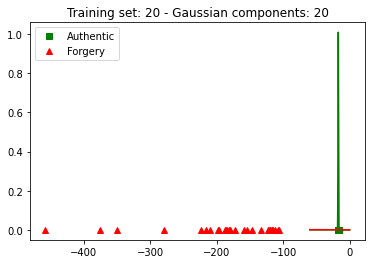

In [10]:
# change this range for your set
x = np.arange(-60, 0, 0.01)

aProb = norm.pdf(x, loc=aMu, scale=aStd)
fProb = norm.pdf(x, loc=fMu, scale=fStd)
plt.plot(x, aProb, 'g')
plt.plot(aScores, np.zeros(len(aScores)), 'gs', lw=2, label='Authentic')
plt.plot(x, fProb, 'r')
plt.plot(fScores, np.zeros(len(fScores)), 'r^', lw=2, label='Forgery')
plt.legend();
plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));

#### Based on your data, might be difficult to see the distributions together. Plot in separated images is one solution:

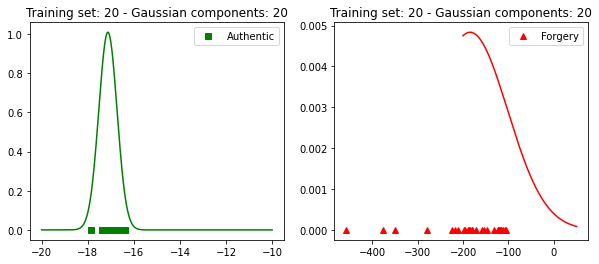

In [11]:
plt.figure(figsize=(10,4))

# Authentic set
x = np.arange(-20, -10, 0.01)
aProb = norm.pdf(x, loc=aMu, scale=aStd)

plt.subplot(1,2,1)
plt.plot(x, aProb, 'g')
plt.plot(aScores, np.zeros(len(aScores)), 'gs', lw=2, label='Authentic')
plt.legend();
plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));


# Forged (impostor) set
x = np.arange(-200, 50, 0.01)
fProb = norm.pdf(x, loc=fMu, scale=fStd)

plt.subplot(1,2,2)
plt.plot(x, fProb, 'r')
plt.plot(fScores, np.zeros(len(fScores)), 'r^', lw=2, label='Forgery')
plt.legend();
plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));

## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

## Introduction 
The purpose of this laboratory exercise is to expand upon the previous lab 2 and better classify the genuine and impostor data. During this lab we will ingest the same signature data we generated using the tablets. The training of the model is based on the Expectation Maximization algorithm. The scores are calculated using the Gaussian Mixture Model. Using these tools we will be able to find a mean and standard deviation that will hopefully separate the genuine from impostor data.

**Specific Questions**

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (4 marks): Create  your own data (three sets of signatures recorded as `.csv` files), or the data provided on D2L. Use the sample Notebook file `Lab3-SigVerif GMM.ipynb`  to classify set 1 (genuine) and set 2 (impostor). Follow the instructions described in  Section 2.2 and repeat this process for 2 different set of parameters (the number of signatures used for training, and the number of Gaussian mixture components, for example 20, 30, 40, ...), total 4 different pairs. In your report, include the illustrations of the distributions for these 4 sets of parameters. Include the 4 sets of distribution plots (figures) for your report. Include a brief analysis of how varying the above parameters influence  the classification results.
		
	 Plot the matching scores' PDFs of the *authentic* (genuine) and *forged* (impostor) sets. Find  the mean ($\mu$) and standard deviation ($\sigma$) for the genuine and impostor scores (variables `aMu`, `fMu`, and `aStd`, `fStd`, respectively). Use two other different sets of parameters, see the difference of plotting the pair of curves (authentic and impostor) together and separately. 

In [12]:
base_dir = os.getcwd() + '/custom-sig/'

# "genuine" and "impostor" sub-directories
dir_authentic = base_dir + 'genuine/'
dir_impostor = base_dir + 'impostor/'

# amount of signatures to be loaded
total_signatures = 30
numForgedSigs = 30

# lists to store the loaded signatures
auth_lst = []
imp_lst = []

# loading 'total_signatures' signatures from both "authentic" and "impostor" 
for i in range(total_signatures):
    # columns: [X, Y, Pressure, Time]
    csv_auth = pd.read_csv(dir_authentic + '%d.csv' % (i+1))
    csv_imp = pd.read_csv(dir_impostor + '%d.csv' % (i+1))

    auth_lst.append(csv_auth.values)
    imp_lst.append(csv_imp.values)

In [13]:
def gmm(NUMTRAININGPATTERNS, NUMGCOMPONENTS):
    
    train_set = np.reshape(auth_lst[0], (-1,4))
    
    for i in range(1,NUMTRAININGPATTERNS):
        sample = np.reshape(auth_lst[i], (-1,4))
        train_set = np.concatenate((train_set, sample), axis=0)
        
    gmm = GaussianMixture(n_components=NUMGCOMPONENTS).fit(train_set)
    
    # Calculate true scores 
    aScores = []
    
    for i in range(NUMTRAININGPATTERNS, total_signatures):
        sample =  np.reshape(auth_lst[i], (-1,4))
        # compute the per-sample average log-likelihood of the given data.
        score = gmm.score(sample)
        #print('%d: %.4f' % (i, score))
        # add the score calculated to the list aScores
        aScores.append(score)
        
    fScores = []
    
    for i in range(numForgedSigs):
        # taking from the impostor
        sample =  np.reshape(imp_lst[i], (-1,4))
        score = gmm.score(sample)
        #print('%d: %.4f' % (i, score))
        fScores.append(score)
        
    return aScores, fScores 


In [14]:
# Caculate scores using various training data and GMM components
aScore_1, fScore_1 = gmm(25, 20)
aScore_2, fScore_2 = gmm(25, 60)
aScore_3, fScore_3 = gmm(15, 20)
aScore_4, fScore_4 = gmm(15, 60)

aScores = [aScore_1, aScore_2, aScore_3, aScore_4]
fScores = [fScore_1, fScore_2, fScore_3, fScore_4]
train = [25, 25, 15, 15]
comp = [20, 60, 20, 60]

In [15]:
for i in range(0, 4):
    print('Training set: {} - Gaussian components: {}\n\taMu = {}\n\taStd = {}\n\tfMu = {}\n\tfStd = {}' \
          .format(train[i], comp[i], np.mean(aScores[i]), np.std(aScores[i]), np.mean(fScores[i]), np.std(fScores[i])))
    print('\n')

Training set: 25 - Gaussian components: 20
	aMu = -17.872606017709533
	aStd = 1.9599709895972164
	fMu = -37.52241515403537
	fStd = 6.0922960597375795


Training set: 25 - Gaussian components: 60
	aMu = -19.49068914400032
	aStd = 2.974915497815267
	fMu = -60.286498049775645
	fStd = 17.06615483785585


Training set: 15 - Gaussian components: 20
	aMu = -17.560517542106687
	aStd = 2.061822791463497
	fMu = -48.41184878896798
	fStd = 15.828767615067381


Training set: 15 - Gaussian components: 60
	aMu = -23.405511069581085
	aStd = 5.614253372830545
	fMu = -97.15012462692793
	fStd = 51.89862055645585




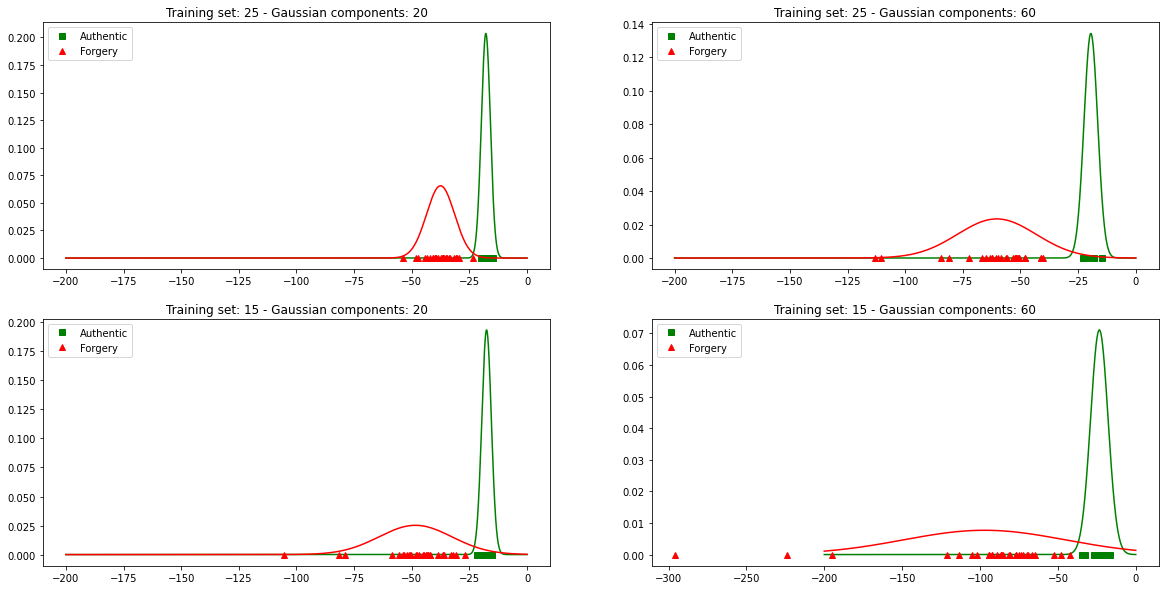

In [16]:
plt.figure(figsize=(20,10))
x = np.arange(-200, 0, 0.01)

for i in range(0, 4):

    plt.subplot(2,2,i+1)
    aProb = norm.pdf(x, loc=np.mean(aScores[i]), scale=np.std(aScores[i]))
    fProb = norm.pdf(x, loc=np.mean(fScores[i]), scale=np.std(fScores[i]))
    plt.plot(x, aProb, 'g')
    plt.plot(aScores[i], np.zeros(len(aScores[i])), 'gs', lw=2, label='Authentic')
    plt.plot(x, fProb, 'r')
    plt.plot(fScores[i], np.zeros(len(fScores[i])), 'r^', lw=2, label='Forgery')
    plt.legend();
    plt.title('Training set: {} - Gaussian components: {}'.format(train[i], comp[i]));

plt.show()

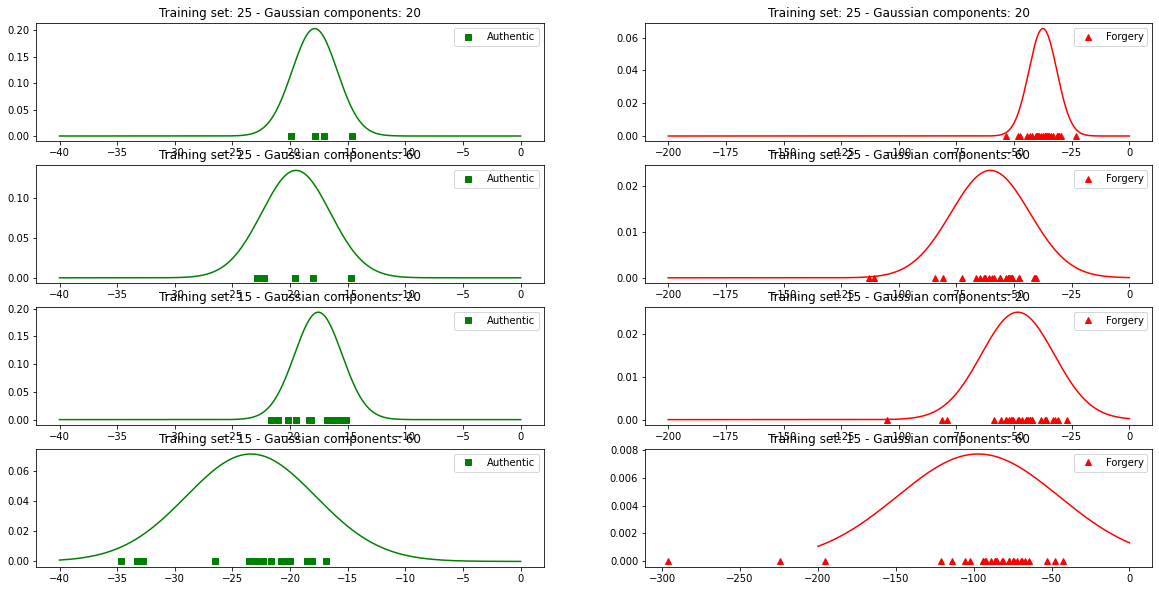

In [17]:
plt.figure(figsize=(20,10))
x_1 = np.arange(-40, 0, 0.01)
x_2 = np.arange(-200, 0, 0.01)
j = 1

for i in range(0, 4):
    
    aProb = norm.pdf(x_1, loc=np.mean(aScores[i]), scale=np.std(aScores[i]))
    fProb = norm.pdf(x_2, loc=np.mean(fScores[i]), scale=np.std(fScores[i]))
    
    plt.subplot(4,2,j)
    plt.plot(x_1, aProb, 'g')
    plt.plot(aScores[i], np.zeros(len(aScores[i])), 'gs', lw=2, label='Authentic')
    plt.legend();
    plt.title('Training set: {} - Gaussian components: {}'.format(train[i], comp[i]));
    
    plt.subplot(4,2,j+1)
    plt.plot(x_2, fProb, 'r')
    plt.plot(fScores[i], np.zeros(len(fScores[i])), 'r^', lw=2, label='Forgery')
    plt.legend();
    plt.title('Training set: {} - Gaussian components: {}'.format(train[i], comp[i]));

    j = j + 2
    
plt.show()

#### Discussion

Increasing the number of guassian components decreases the imposter matching scores. This can be seen by the wider imposter distributions in the graphs using 60 guassian components. Increasing the number of components results in better classification becuase imposter scores are further from the true scores and there is less overlap in the distributions.

Increasing the training data had very little effect on the classification scores. This could be due to the small sample size. There might not be much imporvement from 15 to 25 samples in a small dataset. Thereoretically we should see improvement in the classification scores with increased training data because the model has more information and is less likely to overfit. 

- **Exercise 2** (4 marks): Consider the genuine set and the second set of impostor signatures that are very different (in shape, length, i.e. a different writing or another person signature). 
	Repeat the process as described  in Exercise 1,  for 2 different set of parameters (the number of signatures used for training, and the number of Gaussian mixture components, for example 20, 30, 40, ...), total 4 different pairs. In your report, include the illustrations of the distributions for these 4 sets of parameters. 
	Plot the matching scores' PDFs of the *authentic*  (genuine) and *impostor* sets. Find  the mean ($\mu$) and standard deviation ($\sigma$) for the genuine and impostor scores (variables `aMu`, `fMu`, and `aStd`, `fStd`, respectively). Compare these results against the results of Exercise 1.

In [18]:
base_dir = os.getcwd() + '/custom-sig/'

# "genuine" and "impostor" sub-directories
dir_authentic = base_dir + 'genuine/'
dir_impostor = base_dir + 'other/'

# amount of signatures to be loaded
total_signatures = 30
numForgedSigs = 30

# lists to store the loaded signatures
auth_lst = []
imp_lst = []

# loading 'total_signatures' signatures from both "authentic" and "impostor" 
for i in range(total_signatures):
    # columns: [X, Y, Pressure, Time]
    csv_auth = pd.read_csv(dir_authentic + '%d.csv' % (i+1))
    csv_imp = pd.read_csv(dir_impostor + '%d.csv' % (i+1))

    auth_lst.append(csv_auth.values)
    imp_lst.append(csv_imp.values)

In [19]:
# Caculate scores using various training data and GMM components
aScore_1, fScore_1 = gmm(25, 20)
aScore_2, fScore_2 = gmm(25, 60)
aScore_3, fScore_3 = gmm(15, 20)
aScore_4, fScore_4 = gmm(15, 60)

aScores = [aScore_1, aScore_2, aScore_3, aScore_4]
fScores = [fScore_1, fScore_2, fScore_3, fScore_4]
train = [25, 25, 15, 15]
comp = [20, 60, 20, 60]

In [20]:
for i in range(0, 4):

    print('Training set: {} - Gaussian components: {}\n\taMu = {}\n\taStd = {}\n\tfMu = {}\n\tfStd = {}' \
          .format(train[i], comp[i], np.mean(aScores[i]), np.std(aScores[i]), np.mean(fScores[i]), np.std(fScores[i])))
    print('\n')

Training set: 25 - Gaussian components: 20
	aMu = -17.968122398278656
	aStd = 1.9646785621979515
	fMu = -515.084759001531
	fStd = 935.3126300127727


Training set: 25 - Gaussian components: 60
	aMu = -19.254304066902556
	aStd = 2.6860921799288286
	fMu = -718.2824916082842
	fStd = 1206.7426705369755


Training set: 15 - Gaussian components: 20
	aMu = -17.525911525934724
	aStd = 1.946621464505374
	fMu = -810.2281758873695
	fStd = 1701.1510252135429


Training set: 15 - Gaussian components: 60
	aMu = -22.499753025034448
	aStd = 5.182048145315105
	fMu = -1321.6415553595502
	fStd = 2702.1563257688113




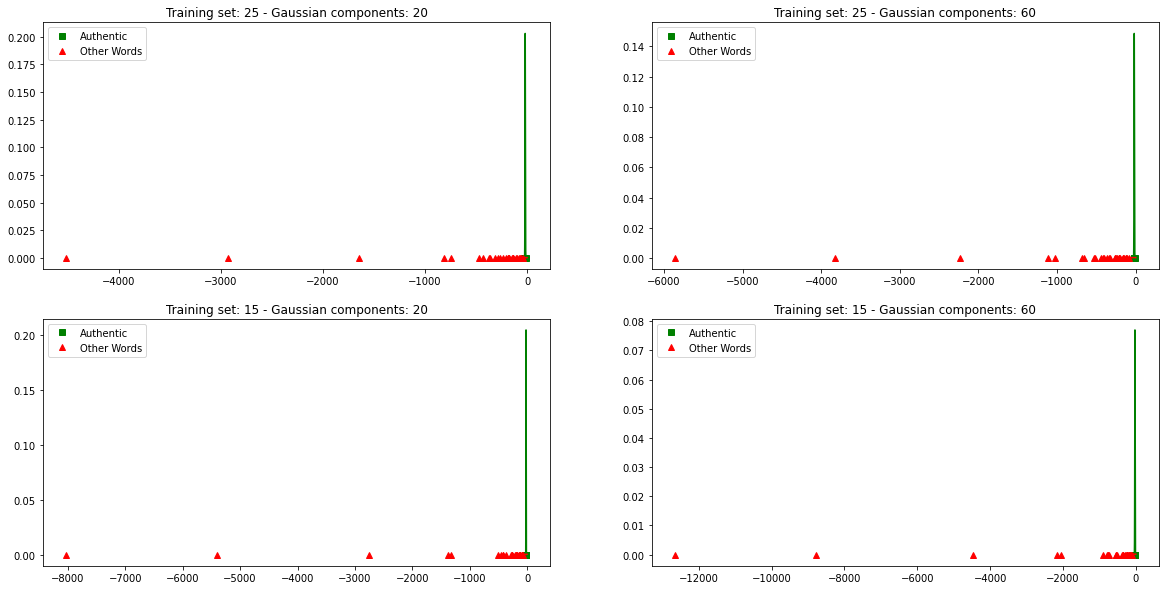

In [21]:
plt.figure(figsize=(20,10))
x = np.arange(-200, 0, 0.01)

for i in range(0, 4):

    plt.subplot(2,2,i+1)
    aProb = norm.pdf(x, loc=np.mean(aScores[i]), scale=np.std(aScores[i]))
    fProb = norm.pdf(x, loc=np.mean(fScores[i]), scale=np.std(fScores[i]))
    plt.plot(x, aProb, 'g')
    plt.plot(aScores[i], np.zeros(len(aScores[i])), 'gs', lw=2, label='Authentic')
    plt.plot(x, fProb, 'r')
    plt.plot(fScores[i], np.zeros(len(fScores[i])), 'r^', lw=2, label='Other Words')
    plt.legend();
    plt.title('Training set: {} - Gaussian components: {}'.format(train[i], comp[i]));

plt.show()

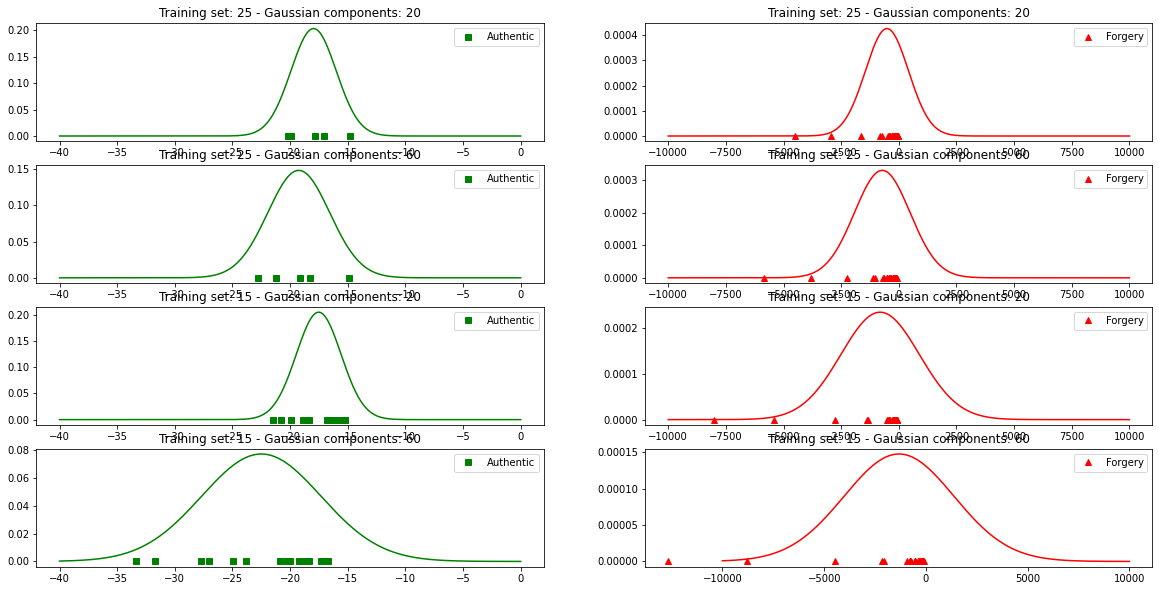

In [22]:
plt.figure(figsize=(20,10))
x_1 = np.arange(-40, 0, 0.01)
x_2 = np.arange(-10000, 10000, 1)
j = 1

for i in range(0, 4):
    
    aProb = norm.pdf(x_1, loc=np.mean(aScores[i]), scale=np.std(aScores[i]))
    fProb = norm.pdf(x_2, loc=np.mean(fScores[i]), scale=np.std(fScores[i]))
    
    plt.subplot(4,2,j)
    plt.plot(x_1, aProb, 'g')
    plt.plot(aScores[i], np.zeros(len(aScores[i])), 'gs', lw=2, label='Authentic')
    plt.legend();
    plt.title('Training set: {} - Gaussian components: {}'.format(train[i], comp[i]));
    
    plt.subplot(4,2,j+1)
    plt.plot(x_2, fProb, 'r')
    plt.plot(fScores[i], np.zeros(len(fScores[i])), 'r^', lw=2, label='Forgery')
    plt.legend();
    plt.title('Training set: {} - Gaussian components: {}'.format(train[i], comp[i]));

    j = j + 2
    
plt.show()

#### Discussion

<span style="color: red;"> These results have a much higher separation than the graphs in exercise 1. This is to be expected because the data is less similar to the genuine data.
 </span>

- **Exercise 3** (2 marks): Consider your plots from Exercise 1 or 2. Formulate a hypothesis $H_0$ about the $\mu$ and $\sigma$ of the entire population of the authentic signatures, and analytically test this hypothesis based on your sample (your 10 or more signatures) given the level of the test significance equal to 0.05 ($\alpha=0.05$, level of confidence: $1-\alpha= 0.95$). Now, change the critical values (choose reasonable values) and evaluate the FRR value.  Evaluate your FRR and FAR. You can do the calculations manually, and include in  your report using the Markdown or taking a photo and adding this photo to the notebook (see Lab 1 on Markdown). 

In [23]:
base_dir = os.getcwd() + '/custom-sig/'

# "genuine" and "impostor" sub-directories
dir_authentic = base_dir + 'genuine/'
dir_impostor = base_dir + 'impostor/'

# amount of signatures to be loaded
total_signatures = 30
numForgedSigs = 30

# lists to store the loaded signatures
auth_lst = []
imp_lst = []

# loading 'total_signatures' signatures from both "authentic" and "impostor" 
for i in range(total_signatures):
    # columns: [X, Y, Pressure, Time]
    csv_auth = pd.read_csv(dir_authentic + '%d.csv' % (i+1))
    csv_imp = pd.read_csv(dir_impostor + '%d.csv' % (i+1))

    auth_lst.append(csv_auth.values)
    imp_lst.append(csv_imp.values)

In [24]:
aScore, fScore = gmm(15, 60)  # Get matching score

print("Genuine scores:\n", aScore, "\n")
print("Imposter scores:\n", fScore, "\n")

print("Mean of genuine scores: ", np.mean(aScore))
print("Std of genuine scores: ", np.std(aScore))

print("Mean of imposter scores: ", np.mean(fScore))
print("Std of imposter scores: ", np.std(fScore))

Genuine scores:
 [-16.00884266332566, -20.148767387138967, -16.49741623166166, -27.385585250145997, -19.576092862977678, -20.690941988033327, -22.955245643747865, -21.950958155350836, -18.751055725779267, -19.518682806774827, -17.25442110676443, -28.18716385067868, -32.810151037374645, -24.282811365291742, -33.21085050439146] 

Imposter scores:
 [-368.70626937463936, -240.42529751662286, -263.1320076507294, -146.14364166414737, -109.17543972103091, -104.24161442459453, -122.98159642210767, -91.3441304329739, -71.72491274703518, -94.0411271040855, -65.36978079201414, -68.3449322393877, -71.78775939765399, -69.34124180846374, -85.40357351336772, -73.32005210144114, -86.39386285674651, -87.9971285179928, -69.46567191619026, -68.66048094358592, -91.52607226487463, -157.1635869452982, -50.55731900207332, -78.36689518475669, -67.92091623415226, -83.6004290645335, -101.9669441420969, -58.92238513087086, -49.309052292239656, -53.42691567649873] 

Mean of genuine scores:  -22.615265771962466
St

In [25]:
# Score Hypothesis 
# mean = -21
# std = 5

In [26]:
# Hypothesis Testing with alpha = 0.05 --------------

mean = -21
std = 5
Z = 1.96  # alpha = 0.05
n = len(aScore)   # Only looking at half

lower_bound = mean-(Z*(std/math.sqrt(n)))
upper_bound = mean+(Z*(std/math.sqrt(n)))

print("Hypothesis: mean = -21   std = 5\n")
print("Accept hypothesis if...\n",  round(lower_bound, 3), " < mean < ", round(upper_bound, 3), "\n")

FN = 0 
FP = 0

for score in aScore:
    if(score<lower_bound or upper_bound<score):
        FN = FN + 1
        
for score in fScore:
    if(lower_bound<score and score<upper_bound):
        FP = FP + 1
        
print("The FRR is: ", round((FN/n)*100, 3), "%")
print("The FAR is: ", round((FP/n)*100, 3), "%")

Hypothesis: mean = -21   std = 5

Accept hypothesis if...
 -23.53  < mean <  -18.47 

The FRR is:  53.333 %
The FAR is:  0.0 %


In [27]:
# Hypothesis testing with manualy chosen boundaries --------------

mean = -21
std = 5
n = len(aScore)   # Only looking at half

lower_bound = -26
upper_bound = -16

print("Hypothesis: mean = -21   std = 5\n")
print("Accept hypothesis if...\n",  round(lower_bound, 3), " < mean < ", round(upper_bound, 3), "\n")

FN = 0 
FP = 0

for score in aScore:
    if(score<lower_bound or upper_bound<score):
        FN = FN + 1
        
for score in fScore:
    if(lower_bound<score and score<upper_bound):
        FP = FP + 1
        
print("The FRR is: ", round((FN/n)*100, 3), "%")
print("The FAR is: ", round((FP/n)*100, 3), "%")

Hypothesis: mean = -21   std = 5

Accept hypothesis if...
 -26  < mean <  -16 

The FRR is:  26.667 %
The FAR is:  0.0 %


#### Discussion

For exercise 3 we trained the GMM on half our data and used the remaining samples to formulate our hypothesis and calculate our type I error. We caluclated the average and standard deviation from our scores to generate the hypothesis: mean=-21 and std=5. Using alpha = 0.05 resulted in a FRR of 66.7% and a FAR of 0%. Since our imposter scores are very different from our genuine scores we could decrease our critical boundaries to achieve a lower FRR. Setting the critical region to -26 < mean < -16 resulted in a FRR of only 26.7%. 

## Conclusion
During this lab we used the Expectation Maximization algorithm to train our Guassian Mixture Model. This provided better classification results compared to Lab 2. Comparing exercise 1 and exercise 2's figures it is obvious that the second imposter set (not signature words) had a lot less similarity to the genuine signature than the first imposter set (forged signature). In exercise 3 we classified genuine and imposter samples using the GMM matching scores. We used 60 GMM components to train our model. This produced very distinct imposter and genuine distributions so we could achieve a lower FRR with larger boundaries.